# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación ARC-TIRADS**

## Alejandro Martínez Hernández

### Notebook 1/3

# **Análisis Exploratorio de datos**

La clasificación TIRADS (Thyroid Imaging Reporting and Data System) son un conjunto de sistemas utilizados para estratificar el riesgo de cáncer en nódulos tiroideos basado en sus características ecográficas observadas en ultrasonido. Existen varios sistemas de TIRADS, pero la mayoría de estos categorizan los nódulos en cinco niveles (TIRADS 1-5) que corresponden a un riesgo creciente de malignidad (Durante et al., 2023; Ha et al., 2021; Hoang et al., 2021).

En 2015, el grupo de investigación CIM@LAB, en colaboración con el IDIME, publicó lo que sería la primera versión de la "Digital Database of Thyroid Ultrasound Images" (DDTI). Esta versión inicial constaba de 99 casos, con 134 imágenes en formato JPG y un archivo '.xml' que contenía anotaciones clínicas realizadas por expertos, además de la información de cada paciente. A lo largo de los años, la base de datos ha sido objeto de actualizaciones periódicas, incorporando nuevos casos para enriquecer su contenido (Pedraza et al., 2015).

Para el año 2023, la DDTI experimentó su última actualización, la cual se llevó a cabo para alinearla con los criterios más recientes establecidos por la ARC-TIRADS. Esta actualización implicó una serie de revisiones, reevaluación de la calidad de las imágenes, modificaciones en las anotaciones, considerando la inclusión de nuevos especialistas. Además, el cambio de formato se diseñó para facilitar la integración de las anotaciones con plataformas más compatibles con las necesidades del profesional clínico. A pesar de estos ajustes, es importante señalar que los cambios implementados no afectan el diagnóstico de malignidad derivado de las imágenes. La reducción en el número de casos disponibles en la base de datos se justifica por la necesidad de cumplir con las demandas de esta actualización. Como se destaca en la documentación de la primera versión de la base de datos, se identificó que no todas las imágenes contaban con las anotaciones apropiadas tras ser evaluadas radiológicamente y confirmadas patológicamente.


Si desea conocer todas las versiones de la base de datos, puede consultar el siguiente enlace: http://cimalab.unal.edu.co/applications/thyroid/

## **Creación de directorios**

Con la finalidad de hacer más versatil este repositorio, este código gestiona la estructura de carpetas para un proyecto, asegurando que las carpetas necesarias estén presentes y limpias antes de su uso. A estas carpetas no se les hace un seguimiento a través de git. 

El código realiza las siguientes operaciones en el sistema de archivos utilizando Python:

- **recrear_carpeta:** Esta función elimina una carpeta si ya existe y luego la crea de nuevo. Esto es útil para asegurarse de que la carpeta esté vacía antes de agregar nuevos archivos o subcarpetas.

- **crear_subcarpetas:** Esta función crea subcarpetas dentro de una carpeta principal. Puedes especificar una subcarpeta padre dentro de la cual se crearán las nuevas subcarpetas, permitiendo así una estructuración más detallada de los directorios.

**Aplicación de las funciones:** Se utiliza la función recrear_carpeta para asegurar que la carpeta */db_unal* (donde se almacenarán todas las bases de datos y las modificaciones que posteriormente se hagan) esté vacía y luego se recrea. Luego, se crean las subcarpetas */originals* y */organized* dentro de */db_unal*. Finalmente, dentro de la subcarpeta originals de */db_unal*, se crean las subcarpetas */DDTI_V1* y */DDTI_V2*

In [1]:
# Directorios

import os
import shutil

def recrear_carpeta(carpeta):
    """
    Elimina la carpeta especificada si existe y luego la crea de nuevo.
    
    Parámetros:
    carpeta (str): Ruta de la carpeta a recrear.
    """
    if os.path.exists(carpeta):
        shutil.rmtree(carpeta)
    os.makedirs(carpeta)

def crear_subcarpetas(carpeta_principal, subcarpetas, subcarpeta_padre=None):
    """
    Crea subcarpetas dentro de una carpeta principal. Si se especifica una subcarpeta_padre,
    las subcarpetas se crearán dentro de esta.
    
    Parámetros:
    carpeta_principal (str): Ruta de la carpeta principal.
    subcarpetas (list): Lista de nombres de subcarpetas a crear.
    subcarpeta_padre (str): Nombre de la subcarpeta dentro de la cual se crearán nuevas subcarpetas.
    """
    # Determinar la ruta base donde se crearán las subcarpetas
    ruta_base = carpeta_principal if subcarpeta_padre is None else os.path.join(carpeta_principal, subcarpeta_padre)
    
    # Asegurar que la ruta base exista
    if not os.path.exists(ruta_base):
        os.makedirs(ruta_base)
    
    # Crear cada subcarpeta
    for subcarpeta in subcarpetas:
        os.makedirs(os.path.join(ruta_base, subcarpeta), exist_ok=True)


# Aplicación de función
carpeta_principal = 'db_unal'
subcarpetas = ['originals', 'organized']  # Subcarpetas a crear directamente en db_unal
subcarpeta_dentro_v1 = ['DDTI_V1', 'DDTI_V2']  # Subcarpetas a crear directamente en originals

# Recrear la carpeta principal db_unal y crea "originals" y "organized" dentro de ella
recrear_carpeta(carpeta_principal)
crear_subcarpetas(carpeta_principal, subcarpetas)

# Crear subcarpetas adicionales dentro de DDTI_V1
crear_subcarpetas(carpeta_principal, subcarpeta_dentro_v1, 'originals')

## **Importación de datos**

Se recuerda que si bien hay varias versiones de las bases de datos, lo que se ha cambiado han sido las etiquetas, anotaciones o metadata, pero no las imágenes como tal (salvo la cantidad de estas), así que el siguiente código descargará de la nube ambas versione en carpetas comprimidas y las descomprimirá en en las carpetas */DDTI_V1* y */DDTI_V2* dentro de la carpeta */db_unal/originals* eliminando los archivos .zip en el proceso.


In [3]:
# Descarga y descompresión de las bases de datos
 
import requests
import zipfile
import os
import shutil


def vaciar_carpeta(ruta):
    """
    Elimina todo el contenido de una carpeta específica.
    
    Parámetros:
    ruta (str): Ruta de la carpeta a vaciar.
    """
    for contenido in os.listdir(ruta):
        contenido_ruta = os.path.join(ruta, contenido)
        try:
            if os.path.isfile(contenido_ruta) or os.path.islink(contenido_ruta):
                os.unlink(contenido_ruta)
            elif os.path.isdir(contenido_ruta):
                shutil.rmtree(contenido_ruta)
        except Exception as e:
            print(f'Error al eliminar {contenido_ruta}. Razón: {e}')


def descargar_y_extraer_zip(url, ruta_destino):
    """
    Descarga un archivo .zip desde una URL, vacía la carpeta destino,
    extrae el contenido del .zip en la carpeta destino, y elimina el archivo .zip.
    
    Parámetros:
    url (str): URL del archivo .zip a descargar.
    ruta_destino (str): Ruta donde se vaciará el contenido, guardará el .zip y se extraerá su contenido.
    """
    # Asegurarse de que la carpeta destino existe
    if not os.path.exists(ruta_destino):
        os.makedirs(ruta_destino)
    else:
        # Vaciar el contenido de la carpeta destino
        vaciar_carpeta(ruta_destino)
    
    # Continuar con el proceso de descarga y extracción
    nombre_zip = url.split('/')[-1]
    ruta_zip = os.path.join(ruta_destino, nombre_zip)
    
    # Descargar el archivo .zip
    print(f"Descargando {nombre_zip}...")
    respuesta = requests.get(url)
    with open(ruta_zip, 'wb') as archivo_zip:
        archivo_zip.write(respuesta.content)
    print(f"{nombre_zip} descargado exitosamente.")
    
    # Extraer el contenido del .zip
    print(f"Extrayendo el contenido de {nombre_zip}...")
    with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
        archivo_zip.extractall(ruta_destino)
    print(f"Contenido extraído exitosamente en {ruta_destino}.")
    
    # Eliminar el archivo .zip
    os.remove(ruta_zip)
    print(f"{nombre_zip} eliminado para ahorrar espacio \n \n")


# Descargar y extraer primera versión de la base de datos
url_v1 = "http://cimalab.unal.edu.co/applications/thyroid/thyroid.zip"  # Dirección primera versión base de datos
ruta_destino_v1 = "db_unal/originals/DDTI_V1"  # Ruta destino base de datos
descargar_y_extraer_zip(url_v1, ruta_destino_v1)

# Descargar y extraer versión 2023 de la base de datos
url_v2 = "http://cimalab.unal.edu.co/applications/thyroid/DDTI_V2.zip"  # Reemplaza esto con la URL del archivo .zip
ruta_destino_v2 = "db_unal/originals/DDTI_V2"  # Reemplaza esto con la ruta donde deseas guardar y extraer el contenido
descargar_y_extraer_zip(url_v2, ruta_destino_v2)

print('Por favor revise los directorios')


Descargando thyroid.zip...
thyroid.zip descargado exitosamente.
Extrayendo el contenido de thyroid.zip...
Contenido extraído exitosamente en db_unal/originals/DDTI_V1.
thyroid.zip eliminado para ahorrar espacio 
 

Descargando DDTI_V2.zip...
DDTI_V2.zip descargado exitosamente.
Extrayendo el contenido de DDTI_V2.zip...
Contenido extraído exitosamente en db_unal/originals/DDTI_V2.
DDTI_V2.zip eliminado para ahorrar espacio 
 

Por favor revise los directorios


Al revisar los directorios, es notable que la carpeta DDTI_V2.zip tenía una estructura diferente a la carpeta thyroid.zip. Aunque esto no es relevante ni crítico, por razones de orden se procurara homogenizar todas las carpetas con una misma estructura

In [4]:
import os
import shutil

def mover_y_eliminar_carpeta(origen, destino):
    """
    Mueve todo el contenido de la carpeta origen a la carpeta destino
    y luego elimina la carpeta origen.

    Parámetros:
    origen (str): Ruta de la carpeta origen cuyo contenido será movido.
    destino (str): Ruta de la carpeta destino donde se moverá el contenido.
    """

    try:
        # Asegurarse de que la carpeta destino existe, si no, crearla
        if not os.path.exists(destino):
            os.makedirs(destino)

        # Mover cada elemento de la carpeta origen al destino
        print(f"    Se ha movido el contenido de '{origen}' a '{destino}'.")
        for contenido in os.listdir(origen):
            ruta_origen = os.path.join(origen, contenido)
            ruta_destino = os.path.join(destino, contenido)

            # Si el destino ya tiene un archivo/carpeta con el mismo nombre, eliminarlo primero
            if os.path.exists(ruta_destino):
                if os.path.isfile(ruta_destino) or os.path.islink(ruta_destino):
                    os.unlink(ruta_destino)
                elif os.path.isdir(ruta_destino):
                    shutil.rmtree(ruta_destino)
            
            # Mover el contenido
            shutil.move(ruta_origen, destino)
        
        # Eliminar la carpeta origen ahora que está vacía
        os.rmdir(origen)
        print(f"    Se ha eliminado la carpeta '{origen}' \n")

    except:
        print('''Al parecer algunas de las rutas no existe,
        es probable que ya se haya eliminado cuando se 
        ejecutó este código anteriormente''')
        

def cambiar_nombre_carpeta(nombre_actual, nuevo_nombre):
    """
    Cambia el nombre de una carpeta de 'nombre_actual' a 'nuevo_nombre'.

    Parámetros:
    nombre_actual (str): El nombre actual o ruta completa de la carpeta.
    nuevo_nombre (str): El nuevo nombre o ruta completa que se desea asignar a la carpeta.
    """
    try:
        os.rename(nombre_actual, nuevo_nombre)
        print(f"    La carpeta '{nombre_actual}' ha sido renombrada a '{nuevo_nombre}'. \n")
    except OSError as e:
        print(f"    Error: {e}")


print('Las siguientes son las modificaciones en los directorios: \n')

# Simplificar DDTI_V2 en una sola carpeta
carpeta_origen_1 = 'db_unal/originals/DDTI_V2/DDTI_V2'
carpeta_destino_1 = 'db_unal/originals/DDTI_V2'
mover_y_eliminar_carpeta(carpeta_origen_1, carpeta_destino_1)

# Simplificar Radiologist Segmentations en una sola carpeta
carpeta_origen_2 = 'db_unal/originals/DDTI_V2/Radiologist Segmentations/Segmentations'
carpeta_destino_2 = 'db_unal/originals/DDTI_V2/Radiologist Segmentations'
mover_y_eliminar_carpeta(carpeta_origen_2, carpeta_destino_2) 

# Simplificar Radiologist Segmentations en una sola carpeta
carpeta_origen_3 = 'db_unal/originals/DDTI_V2/ResidentSegmentations/Segmentations'
carpeta_destino_3 = 'db_unal/originals/DDTI_V2/ResidentSegmentations'
mover_y_eliminar_carpeta(carpeta_origen_3, carpeta_destino_3) 

# Homogenizar nombres en carpetas
nombre_actual = 'db_unal/originals/DDTI_V2/Radiologist Segmentations'
nuevo_nombre = 'db_unal/originals/DDTI_V2/RadiologistSegmentations'
cambiar_nombre_carpeta(nombre_actual, nuevo_nombre)

Las siguientes son las modificaciones en los directorios: 

    Se ha movido el contenido de 'db_unal/originals/DDTI_V2/DDTI_V2' a 'db_unal/originals/DDTI_V2'.
    Se ha eliminado la carpeta 'db_unal/originals/DDTI_V2/DDTI_V2' 

    Se ha movido el contenido de 'db_unal/originals/DDTI_V2/Radiologist Segmentations/Segmentations' a 'db_unal/originals/DDTI_V2/Radiologist Segmentations'.
    Se ha eliminado la carpeta 'db_unal/originals/DDTI_V2/Radiologist Segmentations/Segmentations' 

    Se ha movido el contenido de 'db_unal/originals/DDTI_V2/ResidentSegmentations/Segmentations' a 'db_unal/originals/DDTI_V2/ResidentSegmentations'.
    Se ha eliminado la carpeta 'db_unal/originals/DDTI_V2/ResidentSegmentations/Segmentations' 

    La carpeta 'db_unal/originals/DDTI_V2/Radiologist Segmentations' ha sido renombrada a 'db_unal/originals/DDTI_V2/RadiologistSegmentations'. 



### ***Dejo esta nota para mi, puesto que necesitaré recordar preguntarle a los encargados de mantenimiento de la base de datos qué significa esa estructura tan diferente respecto a las carpetas de segmentación***

## **Conteo de datos**

Se debe verificar la cantidad de datos a tratar.
Previamente se conoce la cantidad de datos que hay en las DDTI V1 y V2, sin embargo se debe asegurar que la descarga y la descompresión que se realiza en los anteriores pasos sea realizada correctamente.

In [1]:
# Importar las librerías necesarias
import glob

# Definir funciones para la revisión de las DDTI
def revision_DDTI_V1(path_database):
    """
    Revisa la cantidad total de archivos existentes en la primera versión
    de la base de datos (DDTI_V1)
    
    Parámetros:
    path_database (str): Ruta a la carpeta DDTI_V1
    """
    numero_imagenes = glob.glob(path_database + '/*.xml') # Agrupa todos los archivos .xml
    numero_xml = glob.glob(path_database + '/*.jpg' ) # Agrupa todos los archivos .jpg
    cantidad_archivos = len(numero_imagenes) + len(numero_xml) # Realiza la suma total de archivos en la ruta
    
    # Al momento de realizar este trabajo se sabe que el número de archivos
    # en la primera versión es 870
    if cantidad_archivos == 870:
        print('DDTI_V1:')
        print(f'    Se tienen los {len(numero_imagenes)} archivos xml')
        print(f'    Se tienen las {len(numero_xml)} imágenes')
        print('Todo se descargó y descomprimió correctamente \n \n')
    else:
        print(f'''Hubo un error, la cantidad de archivos para la primera versión
              debería ser 870, no {cantidad_archivos}.
              Por favor revise si la base de datos fue alterada en el proceso,
              CIMALAB podría haber hecho modificaciones en la misma.''')


def revision_DDTI_V2(path_database):
    """
    Revisa la cantidad total de archivos existentes en la segunda versión
    de la base de datos (DDTI_V2) según su analista de segmentación
    
    Parámetros:
    path_database (str): Ruta a la carpeta DDTI_V2
    """
    numero_archivos_radiologo = glob.glob(path_database + '/RadiologistSegmentations/*.nii') # Agrupa todos los archivos .nii
    numero_archivos_residente = glob.glob(path_database + '/ResidentSegmentations/*.nii') # Agrupa todos los archivos .nii
    cantidad_archivos = len(numero_archivos_radiologo) + len(numero_archivos_residente) # Realiza la suma total de archivos en la ruta
    
    # Al momento de realizar este trabajo se sabe que el número de archivos
    # en la primera versión es 870
    if cantidad_archivos == 353:
        print('DDTI_V2:')
        print(f'    Se tienen las {len(numero_archivos_radiologo)} anotaciones del radiologo')
        print(f'    Se tienen las {len(numero_archivos_residente)} anotaciones del residente')
        print('Todo se descargó y descomprimió correctamente')
    else:
        print(f'''Hubo un error.
              Por favor revise si la base de datos fue alterada en el proceso,
              CIMALAB podría haber hecho modificaciones en la misma.''')
        

# Revisión de la DDTI_V1
revision_DDTI_V1('db_unal/originals/DDTI_V1')

# Revisión de la DDTI_V2
revision_DDTI_V2('db_unal/originals/DDTI_V2')


DDTI_V1:
    Se tienen los 390 archivos xml
    Se tienen las 480 imágenes
Todo se descargó y descomprimió correctamente 
 

DDTI_V2:
    Se tienen las 179 anotaciones del radiologo
    Se tienen las 174 anotaciones del residente
Todo se descargó y descomprimió correctamente


## **Tabulación de datos**
Las imagenes y otra información de los pacientes solo se encuentran en la DDTI_V1, es por ello que se tabula la información de los archivos .xml.
Posteriormente con esta información se podrá actualizar con la presente en la DDTI_V2.

In [2]:
# Importar las librerías necesarias
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Inicializar listas para almacenar los datos extraídos de los archivos XML
numeros = []
edades = []
sexos = []
composiciones = []
ecogenicidades = []
margenes = []
calcificaciones = []
tirads = []
anotaciones_svg = []

# Especificar el directorio que contiene los archivos XML
directorio = 'db_unal/originals/DDTI_V1'

# Iterar sobre cada archivo en el directorio especificado
for filename in os.listdir(directorio):
    # Procesar solo los archivos que terminan con '.xml'
    if filename.endswith('.xml'):
        # Analizar (parse) el archivo XML
        tree = ET.parse(os.path.join(directorio, filename))
        root = tree.getroot()
        
        # Extraer y almacenar información relevante en las listas correspondientes
        numero = root.find('number').text
        numeros.append(int(numero) if numero else None)
        
        edad = root.find('age').text
        edades.append(int(edad) if edad else None)
        
        sexos.append(root.find('sex').text)
        composiciones.append(root.find('composition').text)
        ecogenicidades.append(root.find('echogenicity').text)
        margenes.append(root.find('margins').text)
        calcificaciones.append(root.find('calcifications').text)
        tirads.append(root.find('tirads').text)
        
        # Extraer información de anotaciones en formato SVG
        anotaciones_svg.append(root.find('mark').find('svg').text)

# Crear un diccionario para facilitar la creación del DataFrame
data = {
    'Numero': numeros,
    'Edad': edades,
    'Sexo': sexos,
    'Composicion': composiciones,
    'Ecogenicidad': ecogenicidades,
    'Margenes': margenes,
    'Calcificaciones': calcificaciones,
    'Tirads': tirads
}

# Convertir el diccionario a un DataFrame de pandas para análisis posterior
df_DDTI_V1 = pd.DataFrame(data)

# Imprimir el DataFrame para revisión
df_DDTI_V1

,Numero,Edad,Sexo,Composicion,Ecogenicidad,Margenes,Calcificaciones,Tirads
0,1,NaN,None,None,None,None,None,None
1,10,74.0,F,solid,hyperechogenicity,spiculated,microcalcifications,4b
2,100,39.0,F,predominantly solid,isoechogenicity,well defined,macrocalcifications,4a
3,101,40.0,M,solid,hypoechogenicity,well defined,microcalcifications,5
4,102,28.0,F,solid,isoechogenicity,well defined,microcalcifications,4b
...,...,...,...,...,...,...,...,...
385,95,41.0,u,solid,isoechogenicity,well defined,microcalcifications,4a
386,96,NaN,None,None,None,None,None,None
387,97,77.0,M,None,None,None,None,None
388,98,62.0,F,solid,hyperechogenicity,well defined,non,4a


## **Actualización de datos**
Se recuerda que los datos anteriores corresponden a la primera versión de la DDTI_V1. Según CIM@LAB los nuevos cambios en la reevaluación afectaron la clasificación TIRADS y las anotaciones. 

Para esta actualización se creará una copia del dataframe df_DDTI_V1 y se usará el archivo "clasificación.xlsx" de la carpeta */db_unal/originals/DDTI_V2/RadiologistSegmentations* 

### Importar datos DDTI_V2
Se carga el archivo  "clasificación.xlsx"

In [3]:
import pandas as pd

def cargar_excel_a_dataframe(ruta_archivo):
    """
    Carga un archivo de Excel en un DataFrame de pandas.
    
    Parámetros:
    ruta_archivo (str): La ruta completa al archivo de Excel.
    
    Retorna:
    DataFrame: Un DataFrame que contiene los datos del archivo de Excel.
    """
    try:
        # Usar pandas para leer el archivo de Excel
        df = pd.read_excel(ruta_archivo)
        
        # Retorna el DataFrame cargado
        return df
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return None

# Ruta al archivo de Excel
ruta_archivo = 'db_unal/originals/DDTI_V2/RadiologistSegmentations/clasificación.xlsx'

# Cargar el archivo de Excel en un DataFrame
df_DDTI_V2 = cargar_excel_a_dataframe(ruta_archivo)

# Mostrar las primeras filas del DataFrame para verificar
df_DDTI_V2.head()


,PATIENT NUM,EXPERIENCED RADIOLOGIST,Unnamed: 2,Unnamed: 3
0,NaN,TIRADS,SEGMENTATION,NaN
1,1_1,5,YES,NaN
2,1_2,5,YES,NaN
3,2_1,4,YES,NaN
4,3_1,4,YES,NaN


### Limpieza DDTI_V2
En los datos cargados en el archivo "clasificación.xlsx" hay algunos cuya clasificación del sistema TIRADS no es clara o no contiene la anotación.
La limpieza se realiza de la siguiente manera:
- Eliminar la columna Unnamed: 3
- Organizar encabezados
- Eliminar filas que SEGMENTATION sea "NO" o "NOT CLEAR"
- Eliminar filas que TIRADS sea "NOT CLEAR"
- Eliminar todas las filas con valores NULL, NAN o NONE

In [4]:
df_DDTI_V2 =  df_DDTI_V2.drop(df_DDTI_V2.columns[3], axis=1) # Eliminar la columna Unnamed: 3

 # Organizar encabezados: Cambiar nombres
df_DDTI_V2 = df_DDTI_V2.rename(columns={'PATIENT NUM':'Numero_imagen',
                                   'EXPERIENCED RADIOLOGIST':'TIRADS',
                                   'Unnamed: 2': 'Segmentacion'})

df_DDTI_V2 = df_DDTI_V2.drop([0]) # Organizar encabezados: Eliminando fila inaportante
 
df_DDTI_V2 = df_DDTI_V2[df_DDTI_V2['Segmentacion']=='YES'] # Eliminar filas que "Segmentacion" sea "NO" o "NOT CLEAR"

df_DDTI_V2.dropna() # Eliminar todas las filas con valores NULL, NAN o NONE

,Numero_imagen,TIRADS,Segmentacion
1,1_1,5,YES
2,1_2,5,YES
3,2_1,4,YES
4,3_1,4,YES
5,4_1,3,YES
...,...,...,...
171,146_1,3,YES
172,147_1,5,YES
173,148_1,4,YES
174,149_1,5,YES


### Actualizar el df_DDTI_V1 con df_DDTI_V2

Se uniran los dos dataframes filtrando los valores de df_DDTI_V1 tal que los pacientes también se encuentren reportados en df_DDTI_V2

In [5]:
import pandas as pd

def preparar_y_unir_dfs(df_A, df_B):
    """
    Prepara y une dos DataFrames basándose en una columna específica de cada uno.
    
    Parámetros:
    df_A (DataFrame): El primer DataFrame con la columna "Numero paciente".
    df_B (DataFrame): El segundo DataFrame con la columna "Numero".
    
    Retorna:
    DataFrame: Un nuevo DataFrame resultado de unir df_A y df_B.
    """

    # Organizar encabezados: Cambiar nombres
    df_B = df_B.rename(columns={'Numero':'Paciente'})

    # Preparar df_A creando una nueva columna que extraiga el número antes del guión bajo
    # Utiliza la función split y toma la primera parte [0]
    df_A['Numero_simplificado'] = df_A['Numero_imagen'].apply(lambda x: x.split('_')[0])
    
    # Convertir "Numero_simplificado" a numérico para asegurar una correcta unión
    df_A['Numero_simplificado'] = pd.to_numeric(df_A['Numero_simplificado'])

    # Convertir "TIRADS" a númerico para posterior análisis
    df_A['TIRADS'] = pd.to_numeric(df_A['TIRADS'])
    
    # Unir df_A y df_B basándose en "Numero_simplificado" de A y "Numero" de B
    df_unido = pd.merge(df_A, df_B, left_on='Numero_simplificado', right_on='Paciente')
    
    # Eliminar la columna 'Numero_simplificado' si no se necesita
    df_unido.drop('Numero_simplificado', axis=1, inplace=True)
    
    return df_unido

# Unir dataframes df_DDTI_V1 y df_DDTI_V2
df_actualizado = preparar_y_unir_dfs(df_DDTI_V2, df_DDTI_V1)
df_actualizado =  df_actualizado.drop(df_actualizado.columns[10], axis=1) # Eliminar la columna desactualizada tirads
df_actualizado


,Numero_imagen,TIRADS,Segmentacion,Paciente,Edad,Sexo,Composicion,Ecogenicidad,Margenes,Calcificaciones
0,1_1,5.0,YES,1,NaN,None,None,None,None,None
1,1_2,5.0,YES,1,NaN,None,None,None,None,None
2,2_1,4.0,YES,2,49.0,F,solid,hyperechogenicity,well defined,non
3,3_1,4.0,YES,3,31.0,F,spongiform,isoechogenicity,well defined,microcalcifications
4,4_1,3.0,YES,4,37.0,F,spongiform,isoechogenicity,well defined,microcalcifications
...,...,...,...,...,...,...,...,...,...,...
167,146_1,3.0,YES,146,NaN,None,None,None,None,None
168,147_1,5.0,YES,147,NaN,None,None,None,None,None
169,148_1,4.0,YES,148,37.0,F,solid,hypoechogenicity,well defined,non
170,149_1,5.0,YES,149,78.0,M,None,None,None,None


Finalmente, relacionado al archivo "clasificación.xlsx', hay algunos ajustes que se deben hacer manualmente y que solo se notan si se revisa la base de datos. 

In [6]:
# Cambios adicionales

# Cambia el valor TIRADS de la imagen 80_2 al mismo valor de la imagen 80_1
df_actualizado.iloc[89, 1] = df_actualizado.iloc[88, 1]

# Agregar valor de la imagen 114_2 que sea igual a los valores de la imagen 114_1
df_actualizado.loc[len(df_actualizado)] = ['114_2', 
                                           df_actualizado.iloc[134, 1], 
                                           df_actualizado.iloc[134, 2], 
                                           df_actualizado.iloc[134, 3], 
                                           df_actualizado.iloc[134, 4],
                                           df_actualizado.iloc[134, 5], 
                                           df_actualizado.iloc[134, 6], 
                                           df_actualizado.iloc[134, 7], 
                                           df_actualizado.iloc[134, 8],
                                           df_actualizado.iloc[134, 9]]

# Ordenar valores por la columna 'Paciente'
df_actualizado = df_actualizado.sort_values('Paciente', ascending=True)

# Ahora reiniciar los índices del DataFrame reordenado
df_actualizado = df_actualizado.reset_index(drop=True)

# Definir el nuevo orden de las columnas
nuevo_orden = ['Paciente', 'Edad', 'Sexo', 'Numero_imagen', 'TIRADS', 'Segmentacion', 'Composicion', 'Ecogenicidad', 'Margenes', 'Calcificaciones']

# Reorganizar las columnas usando el nuevo orden
df_actualizado = df_actualizado[nuevo_orden]

# Verificar los cambios
df_actualizado


,Paciente,Edad,Sexo,Numero_imagen,TIRADS,Segmentacion,Composicion,Ecogenicidad,Margenes,Calcificaciones
0,1,NaN,None,1_1,5.0,YES,None,None,None,None
1,1,NaN,None,1_2,5.0,YES,None,None,None,None
2,2,49.0,F,2_1,4.0,YES,solid,hyperechogenicity,well defined,non
3,3,31.0,F,3_1,4.0,YES,spongiform,isoechogenicity,well defined,microcalcifications
4,4,37.0,F,4_1,3.0,YES,spongiform,isoechogenicity,well defined,microcalcifications
...,...,...,...,...,...,...,...,...,...,...
168,146,NaN,None,146_1,3.0,YES,None,None,None,None
169,147,NaN,None,147_1,5.0,YES,None,None,None,None
170,148,37.0,F,148_1,4.0,YES,solid,hypoechogenicity,well defined,non
171,149,78.0,M,149_1,5.0,YES,None,None,None,None


### Exportar Data Frame

Una vez actualizada la base de datos se exporta como un archivo .csv para seguir trabajando con la misma.

In [7]:
df_actualizado.to_csv('df_actualizado.csv', index=False)

## **Análisis Básico**

Se inicia revisando globalmente el data frame


In [9]:
import pandas as pd
df_actualizado = pd.read_csv('df_actualizado.csv')

In [11]:
# Información sobre el dataframe incluyendo tipos de datos y valores nulos
print('\n\n' + 'Información sobre el dataframe incluyendo tipos de datos y valores nulos \n')
df_actualizado.info()



Información sobre el dataframe incluyendo tipos de datos y valores nulos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Paciente         173 non-null    int64  
 1   Edad             126 non-null    float64
 2   Sexo             127 non-null    object 
 3   Numero_imagen    173 non-null    object 
 4   TIRADS           173 non-null    float64
 5   Segmentacion     173 non-null    object 
 6   Composicion      121 non-null    object 
 7   Ecogenicidad     121 non-null    object 
 8   Margenes         121 non-null    object 
 9   Calcificaciones  122 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 13.6+ KB


Como se filtró inicialmente el dataframe df_DDTI_V1 respecto a los pacientes del df_DDTI_V2, era de esperarse que "Paciente", "Número_imagen", "TIRADS" y "Segmentacion" poseen la misma cantidad de datos (173), sin embargo para el resto de columnas solo se poseen entre el **69.9 - 73.4%** de los datos. Cuando analizamos la cantidad de pacientes, esta es en realidad 150

Dado que el objetivo de este proyecto es desarrollar un modelo de aprendizaje automático, se debe prestar atención a la independencia de los datos. Esto significa que todas las imágenes y anotaciones asociadas a un mismo paciente deben incluirse en un único conjunto de datos, ya sea el de entrenamiento, prueba o validación, pero no distribuirse entre varios.

Por ejemplo, todas las imágenes y anotaciones del paciente 1 (como 1_1.jpg, 1_2.jpg, 1_1.nii, 1_2.nii) deben asignarse exclusivamente al conjunto de entrenamiento o al de prueba. No se deben dividir entre estos conjuntos, ya que distribuir las imágenes y anotaciones de un mismo paciente entre diferentes conjuntos, por ejemplo, colocando 1_1.jpg y 1_1.nii en el conjunto de entrenamiento y 1_2.jpg y 1_2.nii en el de prueba, comprometería la fiabilidad de los resultados obtenidos del modelo, afectando negativamente su rendimiento, sensibilidad y especificidad.


### Visualización de datos categóricos


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def grafico_barras(df, columna, orientacion='vertical'):
    """
    Crea un gráfico de barras con anotaciones para cada barra, con opción de orientación vertical u horizontal.
    Ajusta la orientación de las etiquetas del eje x para gráficos verticales.
    
    Parámetros:
    df (DataFrame): DataFrame de pandas que contiene los datos.
    columna (str): Nombre de la columna en el DataFrame que se quiere graficar.
    orientacion (str): 'vertical' o 'horizontal' para la orientación del gráfico.
    """
    # Configurar el estilo de seaborn para mejorar la estética del gráfico
    sns.set(style="whitegrid")

    # Agrupar los datos y obtener la cuenta para la columna especificada
    data = df[columna].value_counts()

    # Crear la figura y el eje
    plt.figure(figsize=(10, 5))
    if orientacion == 'horizontal':
        ax = data.plot(kind='barh', color=sns.color_palette('Pastel1'))
        xlabel = 'Frecuencia'
        ylabel = columna
    else:
        ax = data.plot(kind='bar', color=sns.color_palette('Pastel1'))
        xlabel = columna
        ylabel = 'Frecuencia'
        # Ajustar la orientación de las etiquetas del eje x para gráficos verticales
        plt.xticks(rotation=0)  # Establece la rotación a 0 grados para horizontal

    # Configuración de los ejes y título
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Distribución de {columna}')
    
    # Añadir etiquetas con los valores totales para cada barra
    for p in ax.patches:
        if orientacion == 'horizontal':
            ax.text(p.get_width() + 0.3, p.get_y() + 0.1, str(int(p.get_width())), va='center')
        else:
            ax.text(p.get_x() + p.get_width()/2., p.get_height() + 0.3, str(int(p.get_height())), ha='center')
    
    # Mostrar el gráfico
    plt.show()

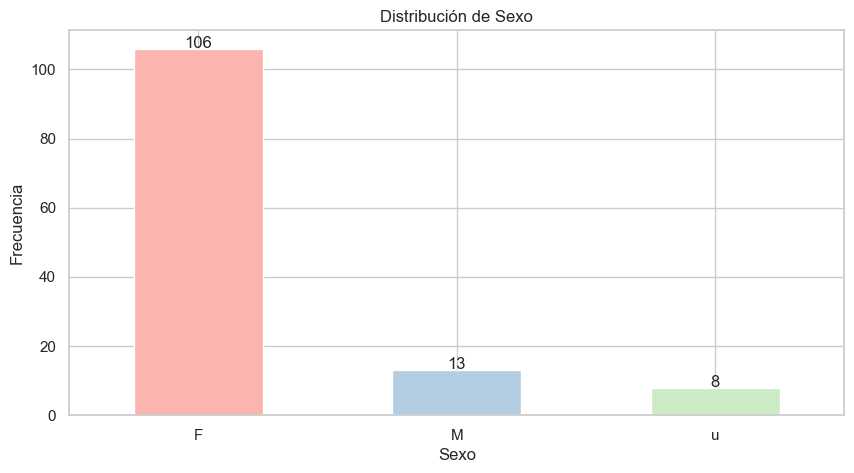

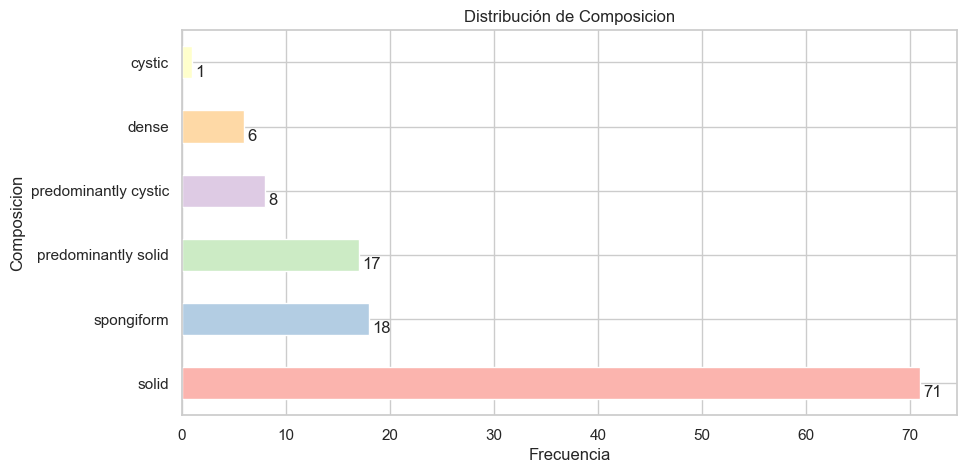

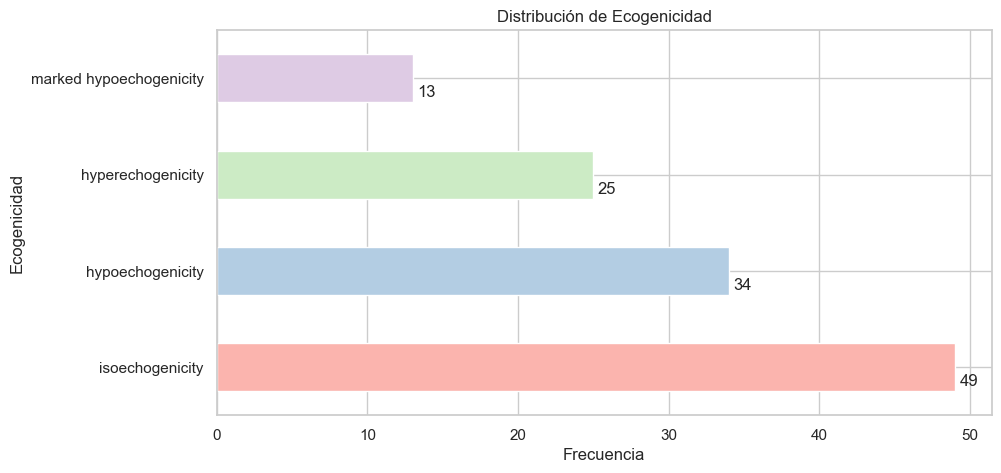

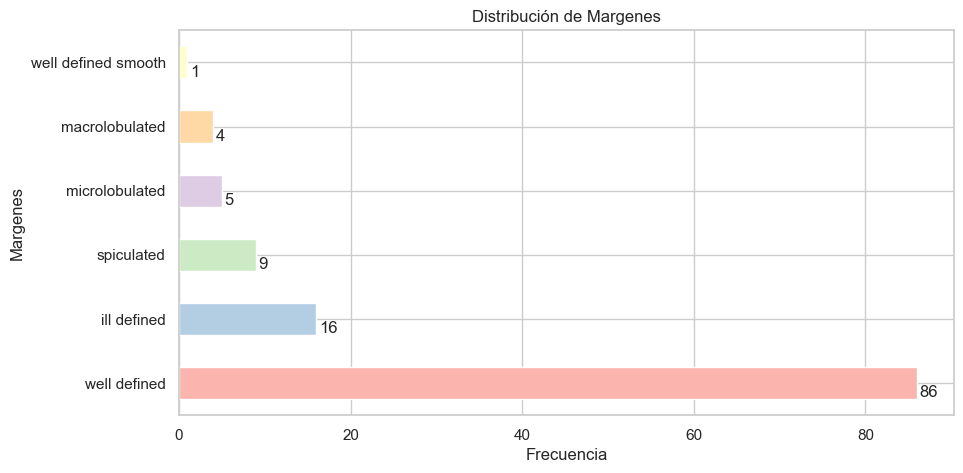

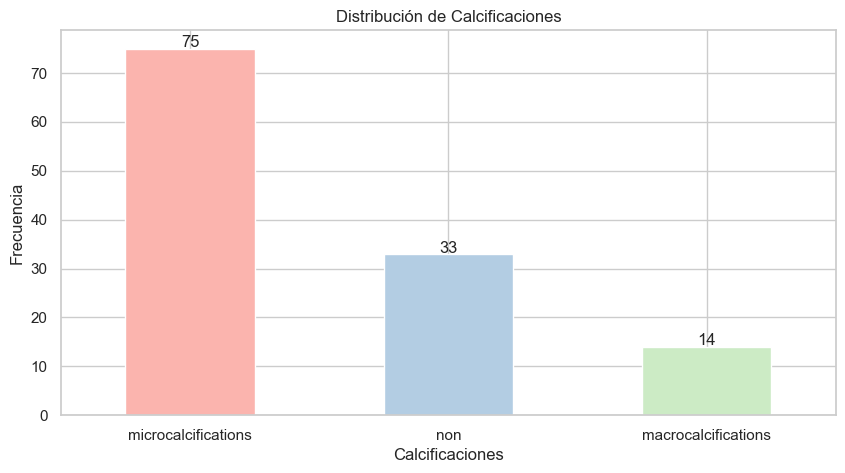

In [39]:
grafico_barras(df_actualizado, 'Sexo', 'vertical')
grafico_barras(df_actualizado, 'Composicion', 'horizontal') 
grafico_barras(df_actualizado, 'Ecogenicidad', 'horizontal')
grafico_barras(df_actualizado, 'Margenes', 'horizontal')
grafico_barras(df_actualizado, 'Calcificaciones', 'vertical')

### Visualización de datos numéricos


In [ ]:
import numpy as np

# Histograma para cada columna numérica
for column in df_actualizado.select_dtypes(include=[np.number]).columns:
    fig = px.histogram(df_actualizado, x=column, title=f"Histograma de {column}")
    fig.show()

# Boxplot para cada columna numérica
for column in df_actualizado.select_dtypes(include=[np.number]).columns:
    fig = px.box(df_actualizado, y=column, title=f"Boxplot de {column}")
    fig.show()


## provisional

Se crea un dataframe provisional para los datos independientes

In [ ]:
df_provisional = pd.DataFrame() # Crea un DataFrame vacío para los datos independientes
df_provisional[['Numero', 'TIRADS', 'Sexo']] = df_actualizado[['Numero', 'TIRADS', 'Sexo']] # Genera una copia de los datos
df_provisional = df_provisional.drop_duplicates().reset_index() # Elimina datos dependientes y reinicia el index
df_provisional # Visualización de datos independientes

KeyError: "['Numero'] not in index"

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def crear_histograma_tirads_con_sumas(df, titulo):
    """
    Crea un histograma para la columna 'TIRADS' de un DataFrame utilizando Plotly y añade anotaciones con las sumas totales.
    
    Parámetros:
    df (DataFrame): DataFrame que contiene la columna 'TIRADS'.
    titulo (str): Título del gráfico.
    """
    # Crear el histograma utilizando Plotly Express
    fig = px.histogram(df, x='TIRADS', nbins=5,
                       title=titulo,
                       labels={'TIRADS': 'Categoría TIRADS'},
                       template='plotly_white',
                       color='Sexo',  # Asumiendo que 'Sexo' es una columna en tu DataFrame
                       )
    
    # Calcular las sumas totales por cada valor único en 'TIRADS'
    suma_totales = df['TIRADS'].value_counts().reset_index()
    suma_totales.columns = ['TIRADS', 'Total']
    
    # Añadir anotaciones de texto para las sumas totales
    for _, row in suma_totales.iterrows():
        fig.add_annotation(x=row['TIRADS'], y=row['Total'],
                           text=str(row['Total']),
                           showarrow=False,
                           yshift=10)
    
    # Agregar títulos a los ejes y ajustes finales al gráfico
    fig.update_layout(
        xaxis_title='Categoría TIRADS',
        yaxis_title='Frecuencia',
        bargap=0.2,  # Espacio entre las barras del histograma
    )
    
    # Mostrar la figura
    fig.show()

# Mostrar Gráficos
crear_histograma_tirads_con_sumas(df_actualizado, "Distribución de TIRADS en el dataframe total")
crear_histograma_tirads_con_sumas(df_provisional, "Distribución de TIRADS de datos independientes")

De la imagen anterior queda bastante claro que las categorias TIRADS se encuentran bastante desbalanceadas. Es probable que no se pueda hacer una clasificación con todos los niveles de TIRADS.



### Exportar dataframe

### Agrupación de datos

Para poder hacer el desarrollo y entrenamiento de los modelos de aprendizaje automático, a causa del desbalanceo presente en los datos será necesario simplificar las clasificaciones TIRADS en dos grupos principales: bajo riesgo y alto riesgo.

#### **Bajo Riesgo (Benigno):** Incluiría TIRADS 1, 2 y 3

Estas categorías tienen un bajo riesgo de malignidad. TIRADS 1 y 2 en varios sistemas de clasificación son típicamente nódulos benignos o incluso ausencia de nódulos, y TIRADS 3 tiene un riesgo relativamente bajo de malignidad (menor al 5% generalmente). Agrupar estos tres puede ayudar a identificar los casos que probablemente no requieran intervenciones invasivas o seguimiento intensivo.

#### **Alto Riesgo (Maligno o sospechoso de malignidad): Incluiría TIRADS 4 y 5**

TIRADS 4 y 5 indican un riesgo moderado y alto de cáncer, respectivamente. TIRADS 4 generalmente se asocia con un riesgo de malignidad del 5-20%, y TIRADS 5 se asocia con un riesgo mayor al 20%. Agrupar estos dos puede facilitar la priorización de pacientes para biopsia y tratamientos subsiguientes.

# Bibliografía

**De momento solo colocaré estás referencias de esta forma. Cuando termine el notebook y esté seguro de todas las referencias las pasaré al formato APA**

(Durante et al., 2023; Ha et al., 2021; Hoang et al., 2021).

(Pedraza et al., 2015).